# Pneumonia Detection

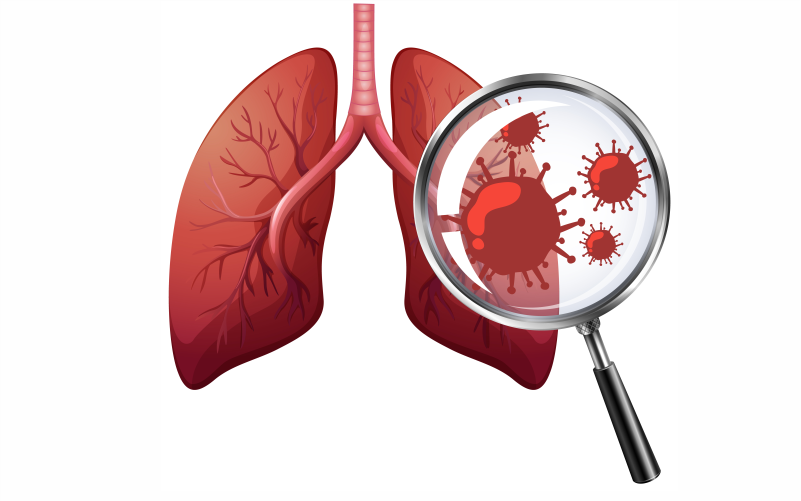

## Aim of this Project

Pneumonia is a severe lung infection that can be life-threatening if not diagnosed and treated in time. Traditional diagnostic methods, such as chest X-rays analyzed by radiologists, can be time-consuming and subject to human error. With the advancement of deep learning techniques, automated detection using Convolutional Neural Networks (CNNs) has shown promising results in medical image analysis. This project aims to develop a CNN-based model to classify chest X-ray images as either *PNEUMONIA* or *NORMAL*. The dataset consists of 5,216 labeled images, which will be used to train and evaluate the model. By leveraging deep learning, this study seeks to enhance the accuracy and efficiency of pneumonia diagnosis, potentially aiding healthcare professionals in early detection and treatment.


## Requirements

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import cv2
import pandas as pd
import os 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D,Dropout,BatchNormalization,Reshape
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D,Dropout,BatchNormalization,Reshape
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
import math
from tensorflow.keras.models import load_model

## Import Data

In [21]:
img_path="chest_xray/train/"
os.listdir(img_path)

['NORMAL', 'PNEUMONIA']

In [23]:
labels=['NORMAL', 'PNEUMONIA']

In [25]:
img_list=[]
label_list=[]
for label in labels:
    for img in os.listdir(img_path+label):
        img_list.append(img_path+label+"/"+img)
        label_list.append(label)

## EDA (Exploratory Data Analysis)

In [29]:
df=pd.DataFrame({"img":img_list,"label":label_list})
df.sample(5)

,img,label
4501,chest_xray/train/PNEUMONIA/person61_bacteria_2...,PNEUMONIA
710,chest_xray/train/NORMAL/NORMAL2-IM-0530-0001.jpeg,NORMAL
1873,chest_xray/train/PNEUMONIA/person1273_virus_21...,PNEUMONIA
1947,chest_xray/train/PNEUMONIA/person130_virus_263...,PNEUMONIA
804,chest_xray/train/NORMAL/NORMAL2-IM-0660-0001.jpeg,NORMAL


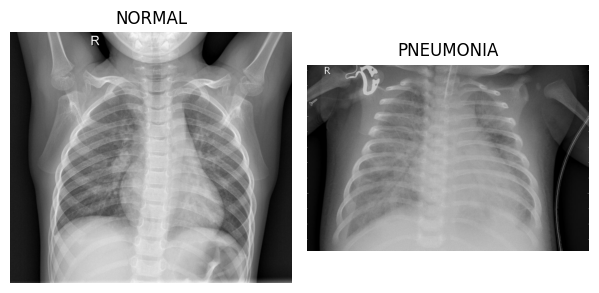

In [31]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(labels):
    sample_img_path = df[df['label'] == label].iloc[0]['img'] 
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)

plt.tight_layout()
plt.show()

In [33]:
df.shape

(5216, 2)

In [35]:
label_encoding_dict={"PNEUMONIA":1,"NORMAL":0}
df["label_encoding"]=df["label"].map(label_encoding_dict)

In [37]:
df["label"].value_counts()

label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

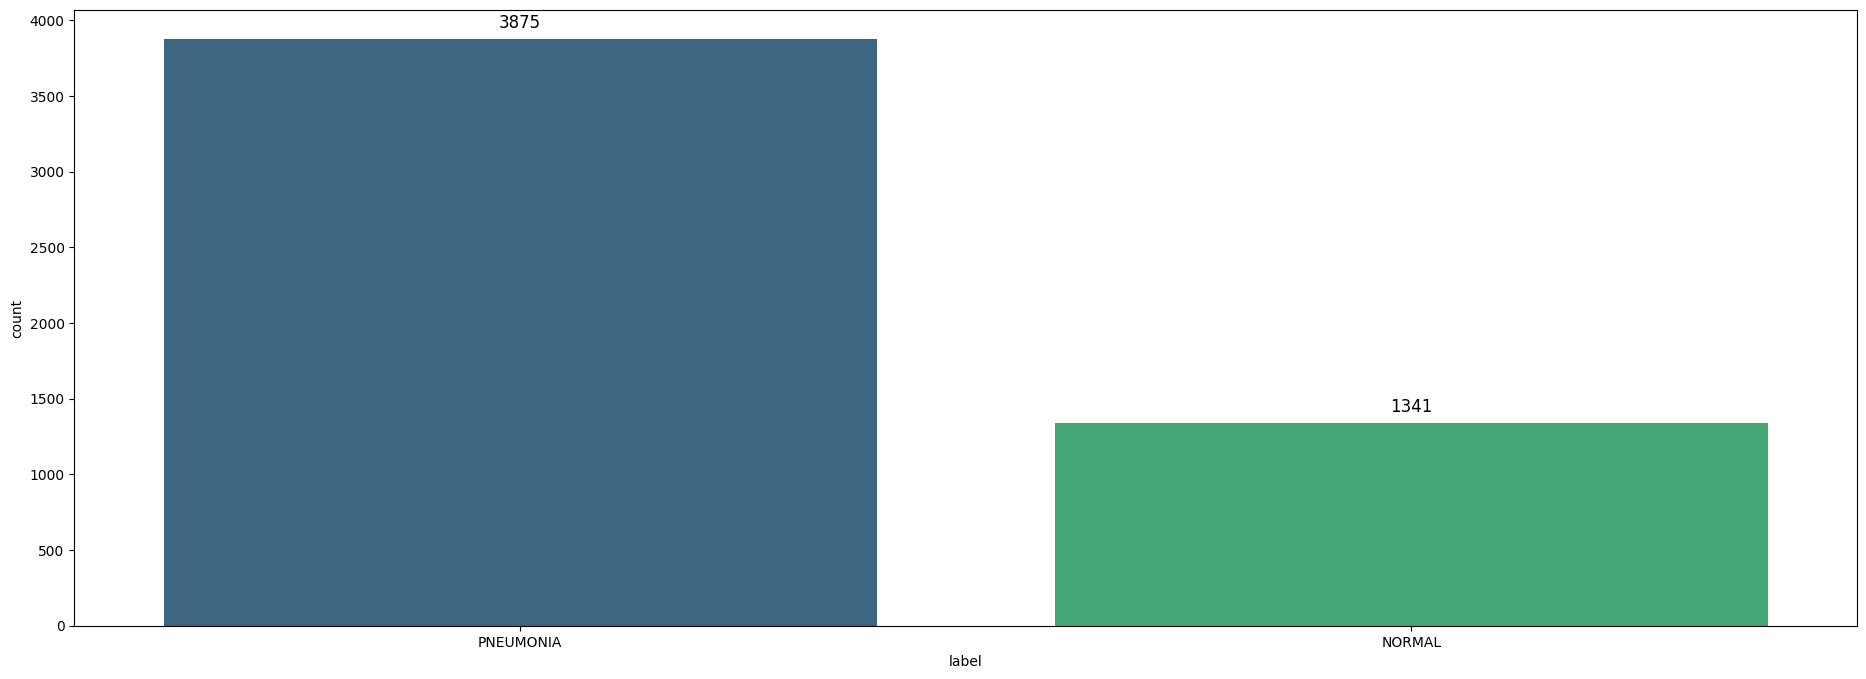

In [39]:
plt.figure(figsize=(23,8))
ax=sns.countplot(x=df["label"],palette="viridis",order=df['label'].value_counts().index)
for p in ax.containers:
    ax.bar_label(p, fontsize=12, color='black', padding=5);

## Preprocess Image

In [41]:
x=[]
for img in df["img"]:
    img=cv2.imread(img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(64,64))
    img=img/255.0
    x.append(img)

In [42]:
x=np.array(x)

In [43]:
y=df[["label_encoding"]]

In [44]:
x.shape,y.shape

((5216, 64, 64, 3), (5216, 1))

## Image Augmentation

In [49]:
from imblearn.over_sampling import SMOTE
x_flat = x.reshape(x.shape[0], -1)  
y_flat = y['label_encoding'].values 
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_flat, y_flat)
x_resampled_images = x_resampled.reshape(-1, 64,64, 3)

In [51]:
x_resampled_images.shape,y_resampled.shape

((7750, 64, 64, 3), (7750,))

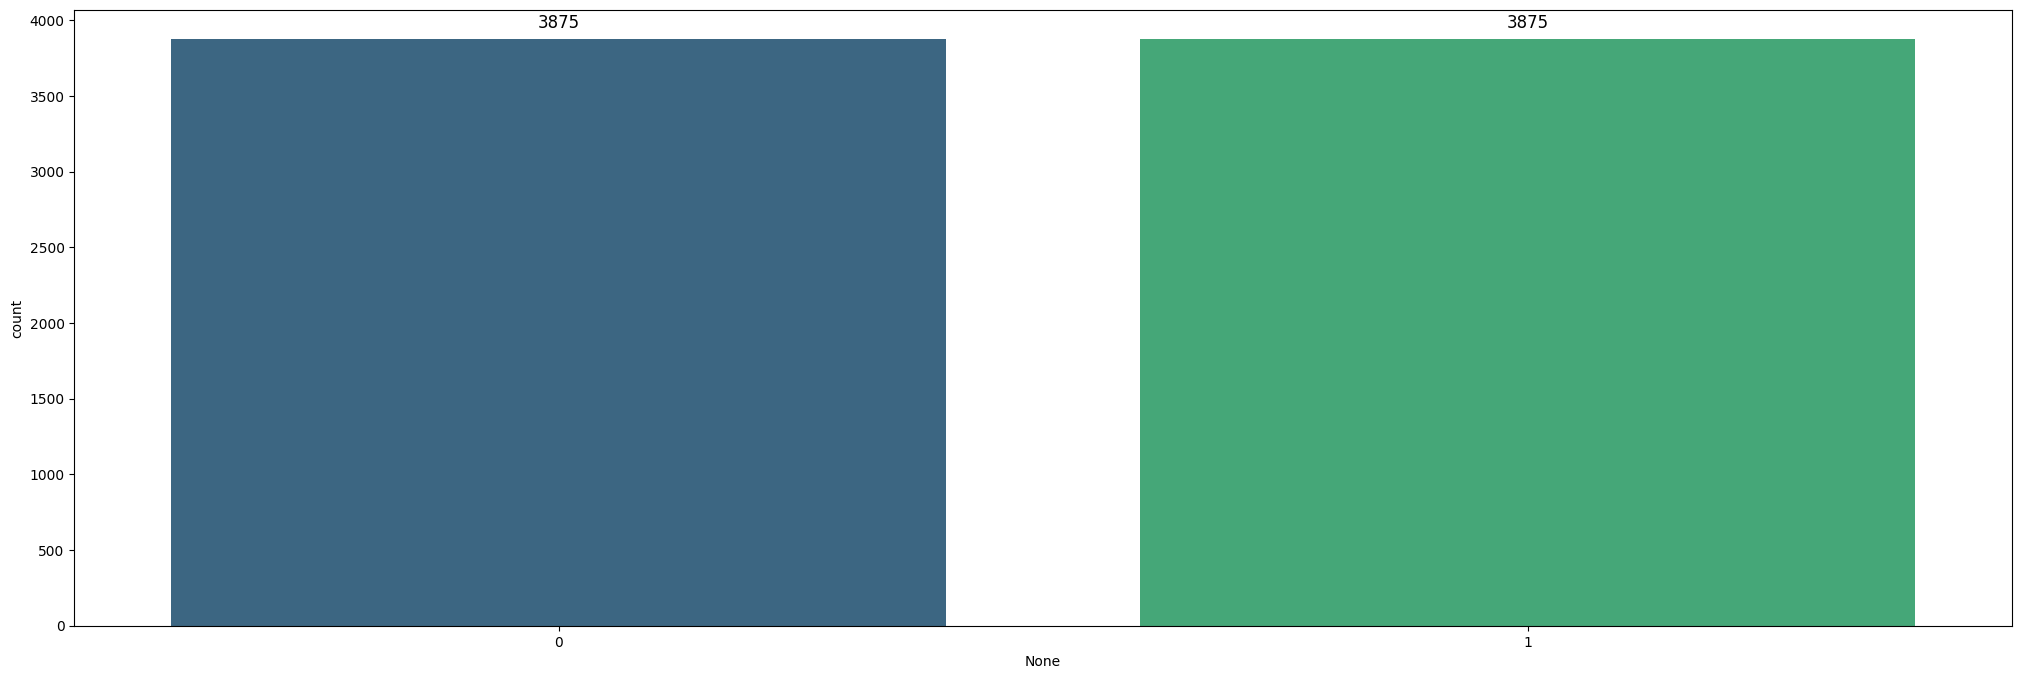

In [53]:
plt.figure(figsize=(25,8))
y_resampled_series=pd.Series(y_resampled)
ax=sns.countplot(x=y_resampled_series,palette="viridis")
for p in ax.containers:
    ax.bar_label(p,fontsize=12,color="black",padding=5);

## Modelling

In [55]:
x_train,x_test,y_train,y_test=train_test_split(x_resampled_images,y_resampled,test_size=.2,random_state=42)

In [57]:
model=Sequential()
model.add(Input(shape=(64,64,3)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [61]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=36,verbose=1)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 117s 674ms/step - accuracy: 0.7994 - loss: 0.5737 - val_accuracy: 0.5026 - val_loss: 14.2753
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 122s 702ms/step - accuracy: 0.9616 - loss: 0.1056 - val_accuracy: 0.5026 - val_loss: 6.2156
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 118s 682ms/step - accuracy: 0.9711 - loss: 0.0837 - val_accuracy: 0.9290 - val_loss: 0.2211
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 113s 652ms/step - accuracy: 0.9753 - loss: 0.0740 - val_accuracy: 0.8058 - val_loss: 2.7832
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 116s 671ms/step - accuracy: 0.9818 - loss: 0.0614 - val_accuracy: 0.9097 - val_loss: 0.3169
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 114s 660ms/step - accuracy: 0.9557 - loss: 0.1244 - val_accuracy: 0.8890 - val_loss: 0.4214
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 111s 640ms/step - accuracy: 0.9842 - loss: 0.0416 - val_accuracy: 0.9800 - val_loss: 0.0511
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 112s 647ms/step - accuracy: 0.9840 

In [62]:
model.save('cnn_model.h5')

## Model Analysis

In [93]:
history.history['accuracy'][-1]

0.9858064651489258

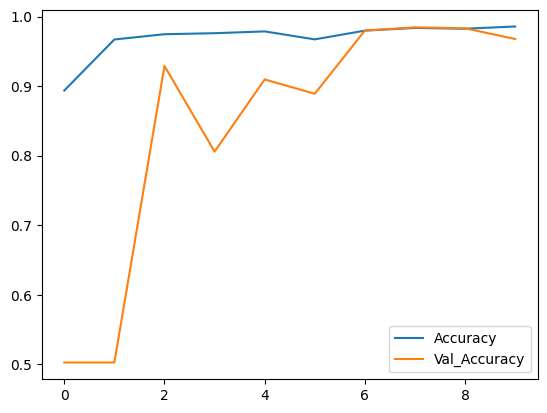

In [95]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();

## Testing the Model

In [65]:
test_path="chest_xray/test/"
os.listdir(test_path)

['NORMAL', 'PNEUMONIA']

In [67]:
labels=['NORMAL', 'PNEUMONIA']

In [69]:
img_list=[]
label_list=[]
for label in labels:
    for img in os.listdir(test_path+label):
        img_list.append(test_path+label+"/"+img)
        label_list.append(label)

In [71]:
df_test=pd.DataFrame({"img":img_list,"label":label_list})
df_test.sample(5)

,img,label
86,chest_xray/test/NORMAL/NORMAL2-IM-0060-0001.jpeg,NORMAL
617,chest_xray/test/PNEUMONIA/person95_bacteria_46...,PNEUMONIA
351,chest_xray/test/PNEUMONIA/person139_bacteria_6...,PNEUMONIA
445,chest_xray/test/PNEUMONIA/person1653_virus_285...,PNEUMONIA
317,chest_xray/test/PNEUMONIA/person127_bacteria_6...,PNEUMONIA


In [73]:
df_test.shape

(624, 2)

In [75]:
label_encoding_dict={"PNEUMONIA":1,"NORMAL":0}
df_test["label_encoding"]=df_test["label"].map(label_encoding_dict)

In [77]:
x_test=[]
for img in df["img"]:
    img=cv2.imread(img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(64,64))
    img=img/255.0
    x_test.append(img)

In [78]:
x_test=np.array(x_test)

In [79]:
y_test=df["label_encoding"]

In [80]:
x_test.shape,y_test.shape

((5216, 64, 64, 3), (5216,))

In [85]:
predictions=model.predict(x_test)
predictions=predictions.argmax(axis=-1)
predictions=np.array(predictions)

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step


In [86]:
accuracy_score(predictions,y_test)

0.9800613496932515

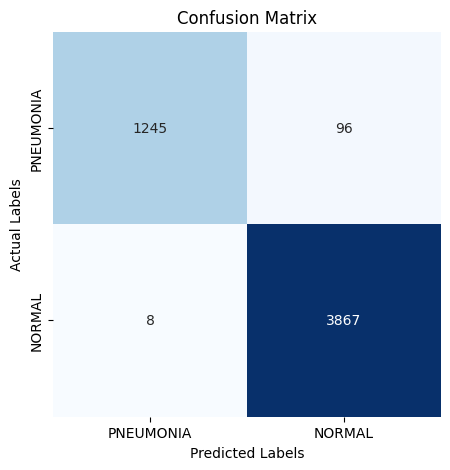

In [89]:
cm = confusion_matrix(y_test, predictions)  

plt.figure(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    xticklabels=label_encoding_dict.keys(),
    yticklabels=label_encoding_dict.keys(),
    cbar=False
)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix');

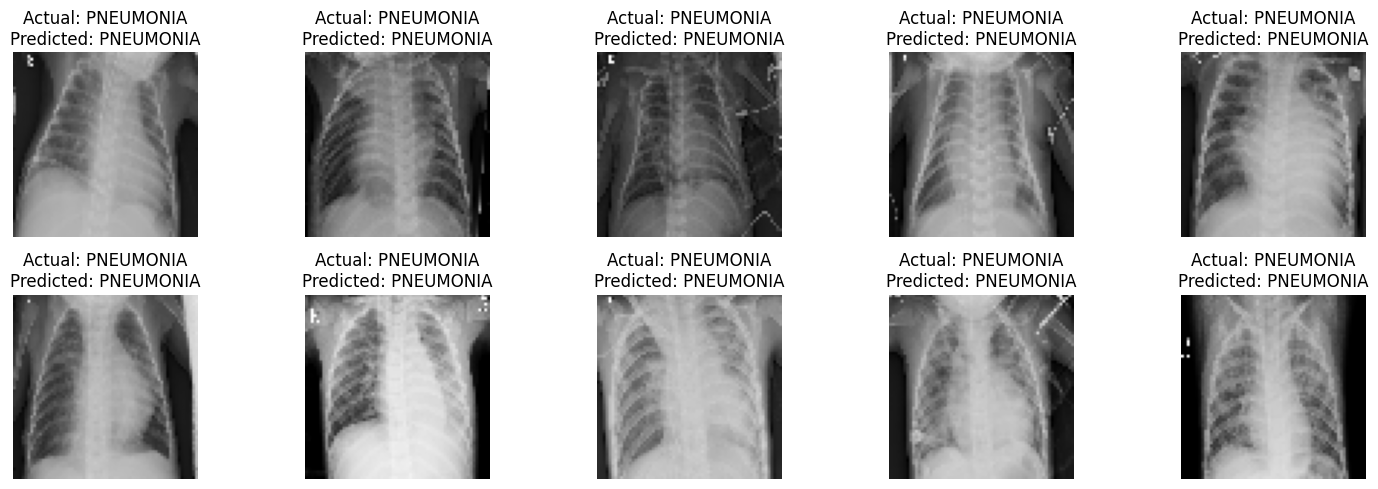

In [101]:
label_decoding_dict = {v: k for k, v in label_encoding_dict.items()}
num_samples = 10 
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)
x_sample = x_test[sample_indices]
y_sample_true = y_test[sample_indices]
y_sample_pred = predictions[sample_indices]

y_sample_true_names = [label_decoding_dict[label] for label in y_sample_true]
y_sample_pred_names = [label_decoding_dict[label] for label in y_sample_pred]

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_sample[i])
    plt.axis('off')
    plt.title(f"Actual: {y_sample_true_names[i]}\nPredicted: {y_sample_pred_names[i]}")

plt.tight_layout()
plt.show()

## Conclusion

In this study, a Convolutional Neural Network (CNN) model was developed to classify chest X-ray images as either *PNEUMONIA* or *NORMAL*. The model achieved an impressive accuracy of **98.01%**, demonstrating its effectiveness in pneumonia detection. 

### Interpretation of Results

The confusion matrix provides deeper insights into the model's performance:
- **True Positives (TP)**: 1245 cases of pneumonia correctly identified.
- **False Negatives (FN)**: 96 pneumonia cases misclassified as normal.
- **True Negatives (TN)**: 3867 normal cases correctly classified.
- **False Positives (FP)**: 8 normal cases misclassified as pneumonia.

### Key Observations:
- The **high number of true positives and true negatives** indicates that the model effectively distinguishes between pneumonia and normal cases.
- The **false negative rate (FN = 96 cases)** is relatively small but still crucial, as misclassifying pneumonia as normal could delay treatment and impact patient health.
- The **false positive rate (FP = 8 cases)** is extremely low, meaning that very few normal cases were incorrectly diagnosed with pneumonia, reducing unnecessary anxiety and treatment.

### Final Thoughts
The CNN model demonstrated **high accuracy and strong classification performance**, making it a promising tool for automated pneumonia detection in medical imaging. However, further improvements could focus on reducing false negatives by enhancing the model's sensitivity to pneumonia cases. Additionally, testing the model on a broader dataset with more diverse cases can help assess its generalizability in real-world clinical settings.